<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Изменение-количества-фичей" data-toc-modified-id="Изменение-количества-фичей-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Изменение количества фичей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Подключаем необходиме библиотеки, создаем глобальные переменные и вышшружаем данные.

In [2]:
import warnings
from time import time

import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor

RANDOM_STATE = 465186

In [3]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('./taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
def get_info(df):
    display(df.sample(5))
    display(df.info())

In [5]:
get_info(df)

,num_orders
datetime,
2018-05-02 02:30:00,12
2018-03-01 18:10:00,12
2018-08-30 23:40:00,39
2018-06-07 04:30:00,21
2018-04-25 04:50:00,7


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

Как видно, данные полные, пропусков нету.

## Анализ

Посмотрим данные целостные ли.

In [6]:
df = df.sort_index(ascending=True)

In [7]:
df.index.is_monotonic

True

Как видно все даные расположены в хронологическом порядке.

Теперь сделамем ресемпл по часам. По скольку нам нужно предсказать количество машин на следующий час, будем применять сэмплирование по часам.

In [8]:
df = df.resample('1H').sum()
get_info(df)

,num_orders
datetime,
2018-03-25 03:00:00,49
2018-07-24 23:00:00,110
2018-05-04 20:00:00,68
2018-03-12 10:00:00,83
2018-04-03 01:00:00,36


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

Посмотрим как менется спрос на графике.

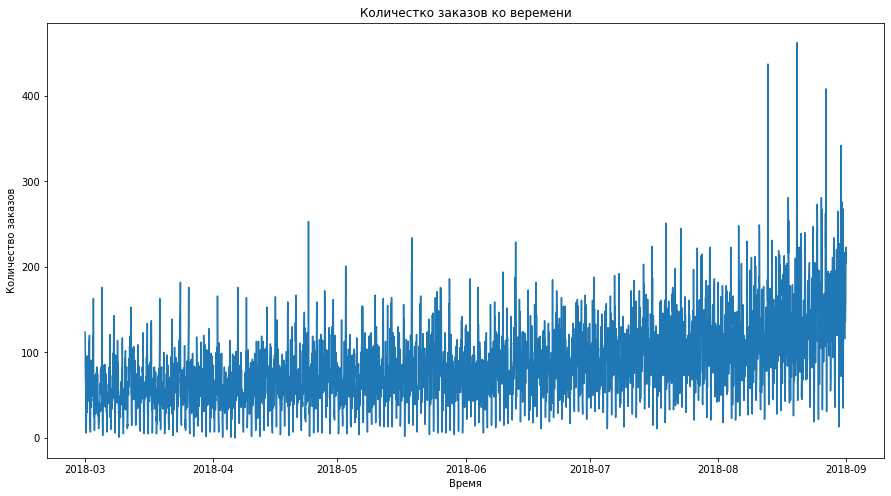

In [9]:
plt.figure(figsize=(15,8))
plt.title('Количестко заказов ко веремени')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.plot(df)
plt.show()

Как видно спрос очень разбросан, нужно попробовть метод скользящего среднего.

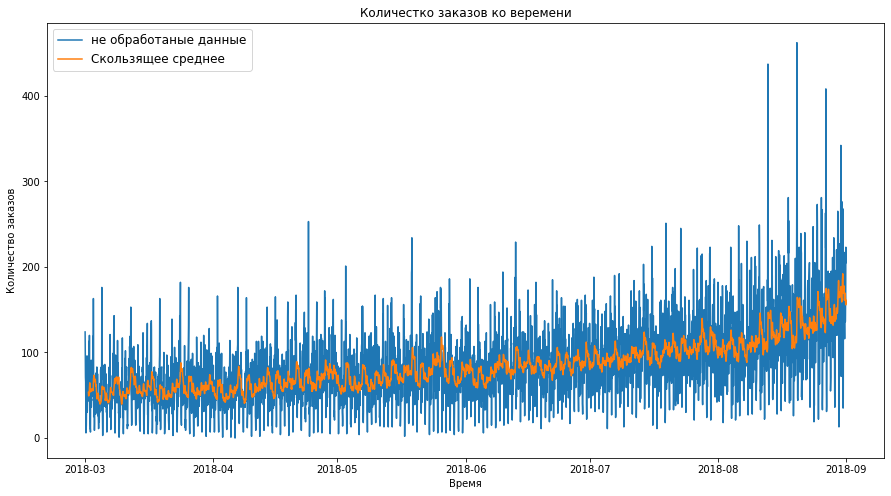

In [10]:
plt.figure(figsize=(15,8))
plt.title('Количестко заказов ко веремени')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.plot(df, label="не обработаные данные")
plt.plot(df.rolling(20).mean(), label='Скользящее среднее')
plt.legend(loc='best', fontsize=12)
plt.show()


Немного лучше. Видно что со врменем спрос растет.

Посмотрим на сезоннсоть и тренды.

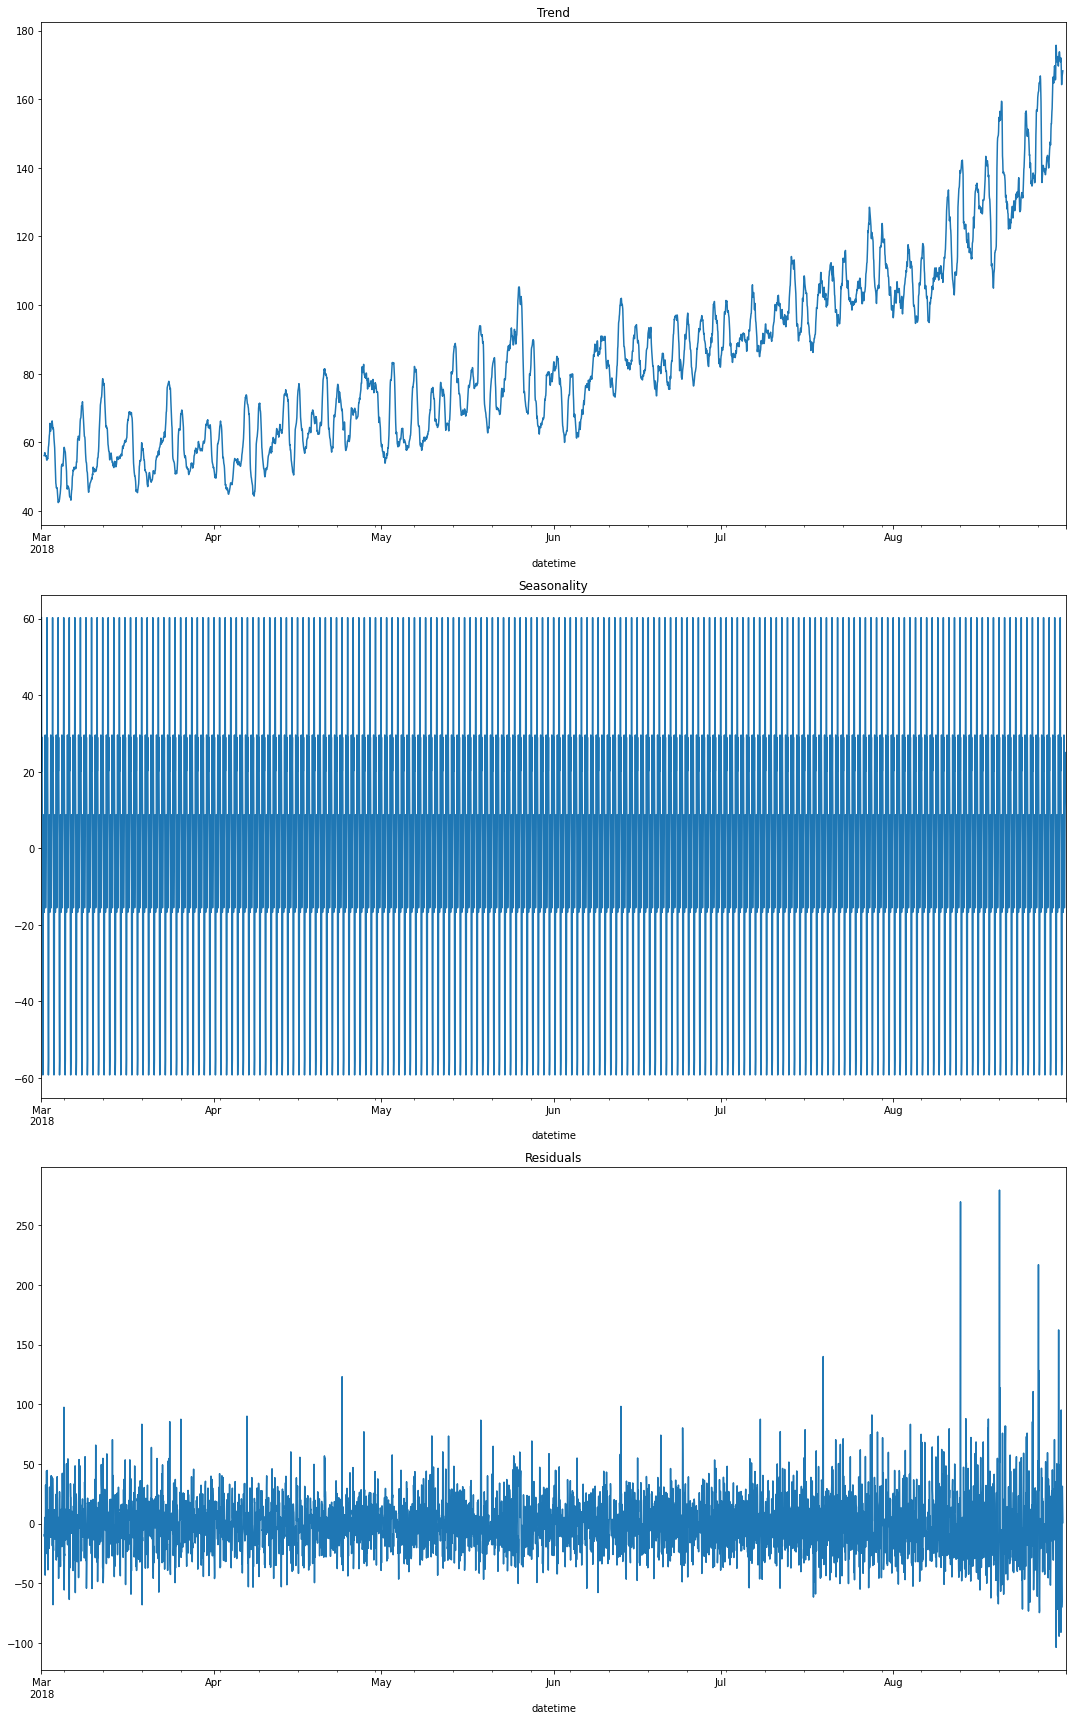

In [11]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 24))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Как видно, тренд идет в рост, что мы и видели на предыдущем графике, сезоность выделить сложно, так как данные всего за пол года. От сюда и такой странный график.

Можно посмотреть на распределение по конкертному месяцу, возьмем на пример апрель.

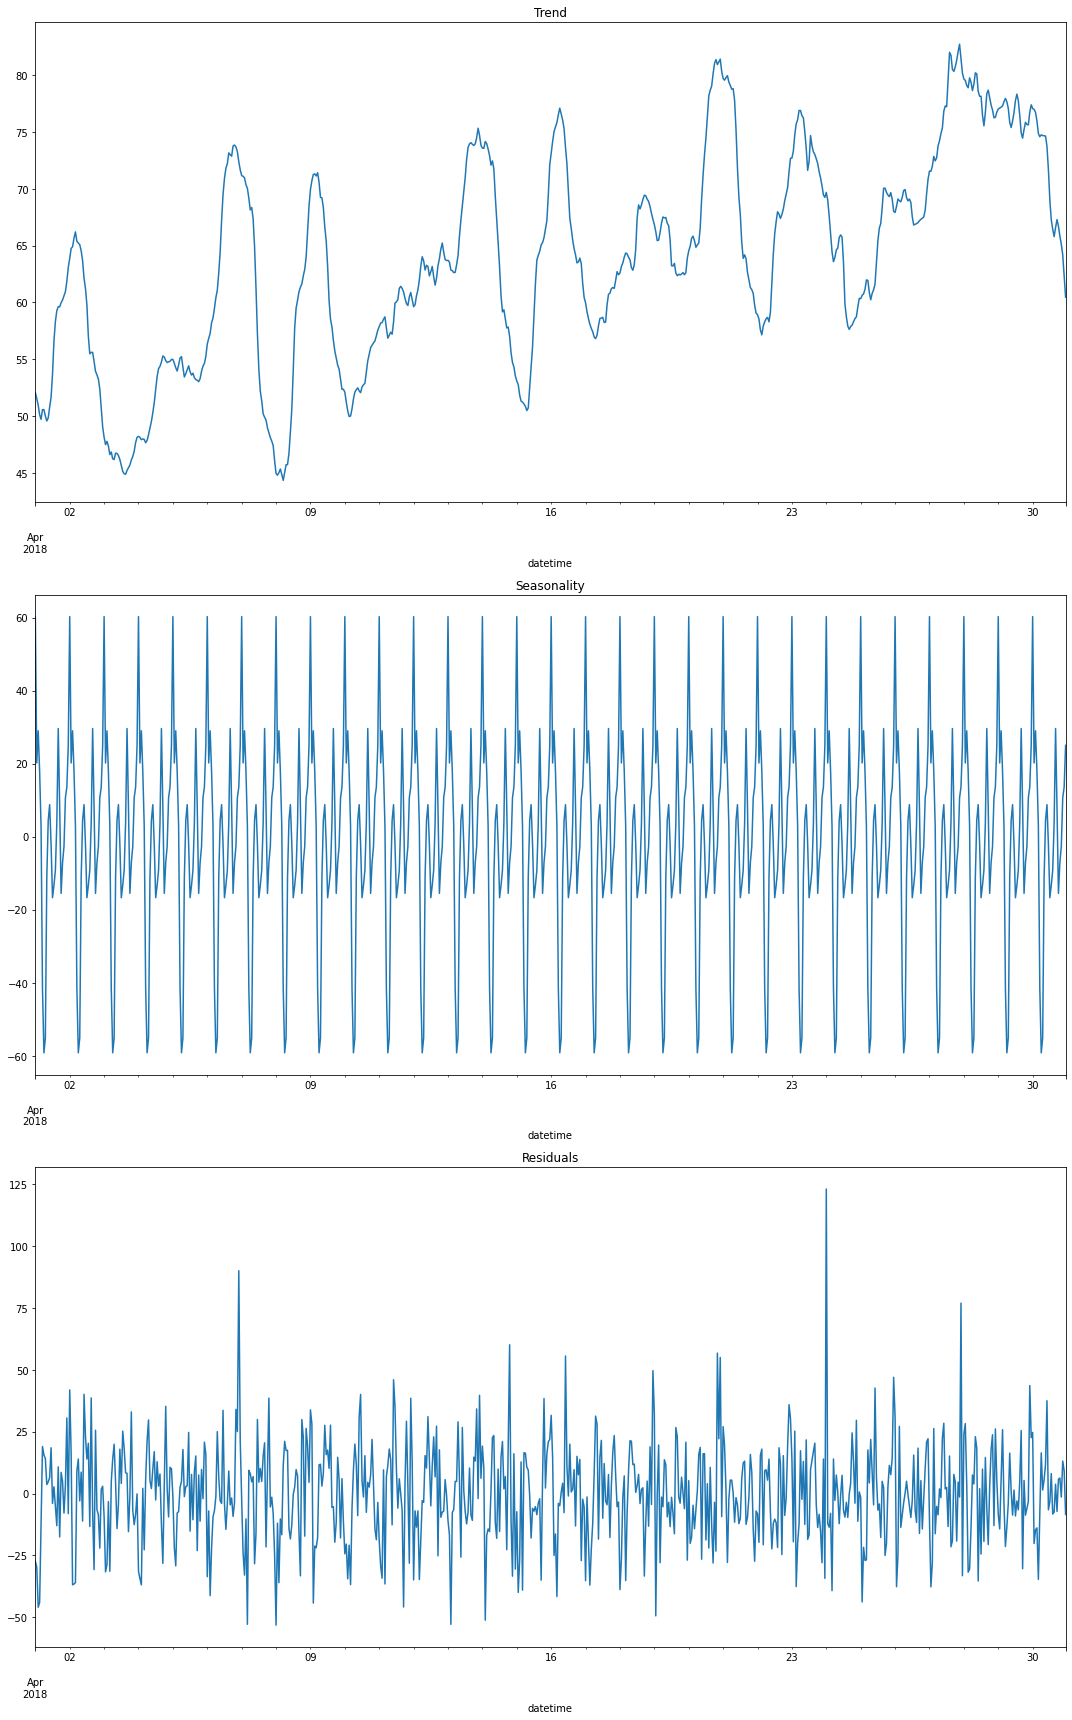

In [12]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 24))

plt.subplot(311)
decomposed.trend['2018-04-01':'2018-04-30'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-04-01':'2018-04-30'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid['2018-04-01':'2018-04-30'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Значения очень случайны, но видно что в тренде значения имеют цикличность, видимо это зависит от дн недели. Можно еще посмотреть на среднее занчение и отклогнение.

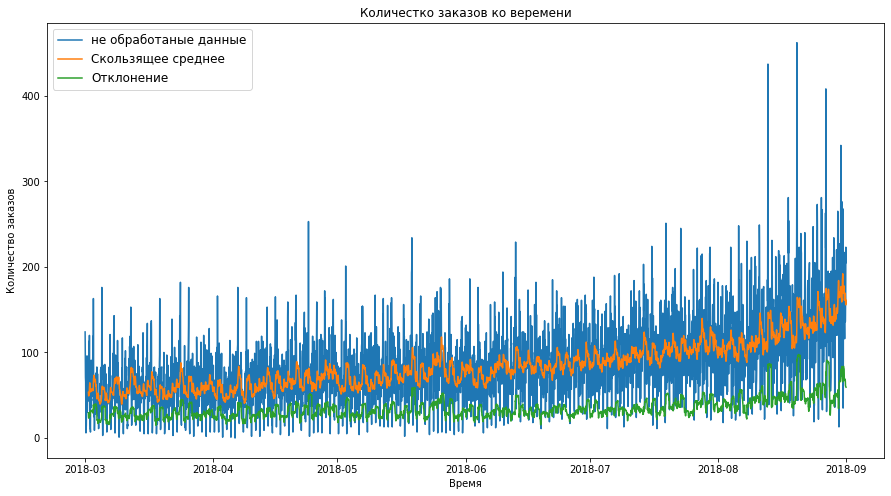

In [13]:
plt.figure(figsize=(15,8))
plt.title('Количестко заказов ко веремени')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.plot(df, label="не обработаные данные")
plt.plot(df.rolling(20).mean(), label='Скользящее среднее')
plt.plot(df.rolling(20).std(), label='Отклонение')
plt.legend(loc='best', fontsize=12)
plt.show()

Видно, что срденее и отклонения меняются очень плавно, можно услвоно сказать что времыной ряд стационарен.

## Обучение

Для обучения модели нам необходимо создать новые приизнаки, разделить выборки на тренировочную, валидационную и тестовую. 

Для новых фичей возьмем дни недели, кажется что для такси это важно, так как у нас данные за пол года, месяц и годььна не нужны, можно добавить дни, так же, можно взять время суток, как фичу. Еще добавим предыдущие значения, а так же скользящее среднее.

In [14]:
def new_features(df, max_lag, rolling_mean_size):
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)
        
    df['rolling_mean'] = df['num_orders'].rolling(rolling_mean_size, closed='left').mean()
    return df.dropna()

In [ ]:
df.head(10)

In [18]:
test = new_features(df, 4, 4)

In [19]:
get_info(test)

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,
2018-03-10 17:00:00,60,10,5,53.0,93.0,37.0,47.0,57.5
2018-06-12 19:00:00,79,12,1,80.0,104.0,129.0,69.0,95.5
2018-07-04 19:00:00,107,4,2,53.0,107.0,148.0,72.0,95.0
2018-03-25 22:00:00,104,25,6,85.0,73.0,68.0,46.0,68.0
2018-07-24 18:00:00,118,24,1,120.0,112.0,114.0,116.0,115.5


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4412 entries, 2018-03-01 04:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4412 non-null   int64  
 1   day           4412 non-null   int64  
 2   dayofweek     4412 non-null   int64  
 3   lag_1         4412 non-null   float64
 4   lag_2         4412 non-null   float64
 5   lag_3         4412 non-null   float64
 6   lag_4         4412 non-null   float64
 7   rolling_mean  4412 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 310.2 KB


None

Все работает, можно пробовать обучать модели.

Для нашей задачи будем ипользовать линейную регресию, катбуст и лес.

### LogisticRegression

Для данной модели будем перебирать только парметр max_iter

In [20]:
features_df = new_features(df, 4, 4)
train, test = train_test_split(features_df, shuffle=False, test_size=0.1)
train, vall = train_test_split(train, shuffle=False, test_size=0.1)
X_train = train.drop(['num_orders'],axis=1)
y_train = train['num_orders']
X_vall = vall.drop(['num_orders'],axis=1)
y_vall = vall['num_orders']
X_test = test.drop(['num_orders'],axis=1)
y_test = test['num_orders']

In [21]:
model_LR = LinearRegression()
model_LR.fit(X_train,y_train)
mse(y_vall, model_LR.predict(X_vall), squared = False)

43.84722436465191

RMSE 44 достаточно не плохой результат. Посмотрим на что способны другие модели.

###  RandomForestRegressor

In [22]:
%%time
best_score = 1000
for depth in range(2,11,4):
    for leaf in range(2,4):
        for split in range(2,4):
            for est in range(700,1001,100):
                start = time()
                model = RandomForestRegressor(random_state=RANDOM_STATE,
                                              max_depth = depth,
                                              min_samples_leaf = leaf,
                                              min_samples_split = split,
                                              n_estimators = est)
                model.fit(X_train,y_train)
                score_model = mse(y_vall, model.predict(X_vall), squared = False)
                if best_score > score_model:
                    best_score = score_model
                    model_cbr = model
                    best_depth = depth
                    best_leaf = leaf
                    best_split = split
                    best_est = est
                print(f'RMSE {score_model}, max_depth {depth}, min_samples_leaf {leaf}, min_samples_split {split}, n_estimators {est}, время {time() - start}')
print('-------------------------------------------------')
print(f'Лучшая модель RMSE {best_score}, max_depth {best_depth}, min_samples_leaf {best_leaf}, min_samples_split {best_split}, n_estimators {best_est}')

RMSE 47.27614009570102, max_depth 2, min_samples_leaf 2, min_samples_split 2, n_estimators 700, время 2.2447969913482666
RMSE 47.274145528940736, max_depth 2, min_samples_leaf 2, min_samples_split 2, n_estimators 800, время 2.792613983154297
RMSE 47.27854989393775, max_depth 2, min_samples_leaf 2, min_samples_split 2, n_estimators 900, время 2.726992130279541
RMSE 47.28161521550402, max_depth 2, min_samples_leaf 2, min_samples_split 2, n_estimators 1000, время 3.01444673538208
RMSE 47.27614009570102, max_depth 2, min_samples_leaf 2, min_samples_split 3, n_estimators 700, время 2.235386371612549
RMSE 47.274145528940736, max_depth 2, min_samples_leaf 2, min_samples_split 3, n_estimators 800, время 2.3870022296905518
RMSE 47.27854989393775, max_depth 2, min_samples_leaf 2, min_samples_split 3, n_estimators 900, время 2.5235443115234375
RMSE 47.28161521550402, max_depth 2, min_samples_leaf 2, min_samples_split 3, n_estimators 1000, время 2.710834503173828
RMSE 47.27614009570102, max_depth 

Лес показал себя лучше 45 на валидационной, прекрасно.

### CatBoostRegressor

In [23]:
%%time
best_score = 1000
for depth in range(2,11,4):
    for iterations in range(100,1101,200):
        for rate in [.7,.8,.9,1]:
            for reg in range(1,9,2):
                start = time()
                model = CatBoostRegressor(random_state=RANDOM_STATE,
                                              max_depth = depth,
                                              iterations = iterations,
                                              learning_rate = rate,
                                              l2_leaf_reg = reg,
                                         logging_level='Silent')
                model.fit(X_train,y_train)
                score_model = mse(y_vall, model.predict(X_vall), squared = False)
                if best_score > score_model:
                    best_score = score_model
                    model_cbr = model
                    best_depth = depth
                    best_iterations = iterations
                    best_rate = rate
                    best_reg = reg
                print(f'RMSE {score_model}, max_depth {depth}, iterations {iterations}, learning_rate {rate}, l2_leaf_reg {reg}, время {time() - start}')
print('-------------------------------------------------')
print(f'Лучшая модель RMSE {best_score}, max_depth {best_depth}, iterations {best_iterations}, learning_rate {best_rate}, l2_leaf_reg {best_reg}')

RMSE 47.11609868885874, max_depth 2, iterations 100, learning_rate 0.7, l2_leaf_reg 1, время 0.6990442276000977
RMSE 47.88400724288302, max_depth 2, iterations 100, learning_rate 0.7, l2_leaf_reg 3, время 0.6328060626983643
RMSE 46.56631045198997, max_depth 2, iterations 100, learning_rate 0.7, l2_leaf_reg 5, время 0.5554714202880859
RMSE 46.60915284680895, max_depth 2, iterations 100, learning_rate 0.7, l2_leaf_reg 7, время 0.46980738639831543
RMSE 48.09572787344447, max_depth 2, iterations 100, learning_rate 0.8, l2_leaf_reg 1, время 0.5370912551879883
RMSE 46.94737954727519, max_depth 2, iterations 100, learning_rate 0.8, l2_leaf_reg 3, время 0.5190844535827637
RMSE 47.55036788023514, max_depth 2, iterations 100, learning_rate 0.8, l2_leaf_reg 5, время 0.5694267749786377
RMSE 47.255470002532135, max_depth 2, iterations 100, learning_rate 0.8, l2_leaf_reg 7, время 0.6107850074768066
RMSE 49.37580457882031, max_depth 2, iterations 100, learning_rate 0.9, l2_leaf_reg 1, время 0.6446208

46 почти как лес достойный результат.

### Изменение количества фичей 

Параметры для моделей подобрали, теперь можно поэксперементровать с фичами. Смотрет буджем на все модели.

In [24]:
best_score = 1000
for lag in range(22,29):
    for roll in range(19,26):
        start = time()
        features_df = new_features(df, lag, roll)
        train, test = train_test_split(features_df, shuffle=False, test_size=0.1)
        train, vall = train_test_split(train, shuffle=False, test_size=0.1)
        X_train = train.drop(['num_orders'],axis=1)
        y_train = train['num_orders']
        X_vall = vall.drop(['num_orders'],axis=1)
        y_vall = vall['num_orders']
        X_test = test.drop(['num_orders'],axis=1)
        y_test = test['num_orders']
        model = CatBoostRegressor(random_state=RANDOM_STATE,
                                      max_depth = 2,
                                      iterations = 100,
                                      learning_rate = .7,
                                      l2_leaf_reg = 5,
                                 logging_level='Silent')
        model.fit(X_train,y_train)
        score_model = mse(y_vall, model.predict(X_vall), squared = False)
        if best_score > score_model:
            best_score = score_model
            model_cbr = model
            best_lag = lag
            best_roll = roll
        print(f'RMSE {score_model}, max_lag {lag}, rolling_mean_size {roll},  время {time() - start}')
print('-------------------------------------------------')
print(f'Лучшая модель RMSE {best_score}, max_lag {best_lag}, rolling_mean_size {best_roll}')

RMSE 37.078856150294406, max_lag 22, rolling_mean_size 19,  время 0.6344156265258789
RMSE 37.35740744651107, max_lag 22, rolling_mean_size 20,  время 0.6061038970947266
RMSE 37.85422099745186, max_lag 22, rolling_mean_size 21,  время 0.7563483715057373
RMSE 39.6701641762528, max_lag 22, rolling_mean_size 22,  время 0.6863038539886475
RMSE 38.204318756792595, max_lag 22, rolling_mean_size 23,  время 0.7038888931274414
RMSE 36.31625808392366, max_lag 22, rolling_mean_size 24,  время 0.6675770282745361
RMSE 37.1927573675278, max_lag 22, rolling_mean_size 25,  время 0.6151633262634277
RMSE 36.702261987039854, max_lag 23, rolling_mean_size 19,  время 0.6312723159790039
RMSE 37.07579401119049, max_lag 23, rolling_mean_size 20,  время 0.9285612106323242
RMSE 37.41359701069832, max_lag 23, rolling_mean_size 21,  время 0.9331779479980469
RMSE 36.84152245533717, max_lag 23, rolling_mean_size 22,  время 0.6315245628356934
RMSE 36.331223021471274, max_lag 23, rolling_mean_size 23,  время 0.6473348

Отлично получилось уменьшить результат до 33, посмотрим теперь на что способен лес.

In [25]:
%%time
best_score = 1000
for lag in range(1,31,5):
    for roll in range(1,32,5):
        start = time()
        features_df = new_features(df, lag, roll)
        train, test = train_test_split(features_df, shuffle=False, test_size=0.1)
        train, vall = train_test_split(train, shuffle=False, test_size=0.1)
        X_train = train.drop(['num_orders'],axis=1)
        y_train = train['num_orders']
        X_vall = vall.drop(['num_orders'],axis=1)
        y_vall = vall['num_orders']
        X_test = test.drop(['num_orders'],axis=1)
        y_test = test['num_orders']
        model = RandomForestRegressor(random_state=RANDOM_STATE,
                                      max_depth = 6,
                                      min_samples_leaf = 2,
                                      min_samples_split = 2,
                                      n_estimators = 1000)
        model.fit(X_train,y_train)
        score_model = mse(y_vall, model.predict(X_vall), squared = False)
        if best_score > score_model:
            best_score = score_model
            model_forest = model
            best_lag = lag
            best_roll = roll
        print(f'RMSE {score_model}, max_lag {lag}, rolling_mean_size {roll},  время {time() - start}')
print('-------------------------------------------------')
print(f'Лучшая модель RMSE {best_score}, max_lag {best_lag}, rolling_mean_size {best_roll}')

RMSE 36.161513449047476, max_lag 1, rolling_mean_size 1,  время 24.515698671340942
RMSE 35.14960349093716, max_lag 1, rolling_mean_size 6,  время 23.928756713867188
RMSE 35.2963679109758, max_lag 1, rolling_mean_size 11,  время 24.73441743850708
RMSE 35.10837061468943, max_lag 1, rolling_mean_size 16,  время 25.492964267730713
RMSE 35.99952075444303, max_lag 1, rolling_mean_size 21,  время 25.393366813659668
RMSE 35.754789884118075, max_lag 1, rolling_mean_size 26,  время 25.794856309890747
RMSE 35.77417370904273, max_lag 1, rolling_mean_size 31,  время 25.374855041503906
RMSE 36.161513449047476, max_lag 6, rolling_mean_size 1,  время 24.782584190368652
RMSE 35.14960349093716, max_lag 6, rolling_mean_size 6,  время 24.973787307739258
RMSE 35.2963679109758, max_lag 6, rolling_mean_size 11,  время 25.37711238861084
RMSE 35.10837061468943, max_lag 6, rolling_mean_size 16,  время 25.5857355594635
RMSE 35.99952075444303, max_lag 6, rolling_mean_size 21,  время 25.215625524520874
RMSE 35.754

Лес обогнеал катбуст на пару сотых, по этому будем использовать именно его.

In [26]:
%%time
best_score = 1000
warnings.filterwarnings("ignore")
for lag in range(1,32,2):
    for roll in range(1,101,5):
        start = time()
        features_df = new_features(df, lag, roll)
        train, test = train_test_split(features_df, shuffle=False, test_size=0.1)
        train, vall = train_test_split(train, shuffle=False, test_size=0.1)
        X_train = train.drop(['num_orders'],axis=1)
        y_train = train['num_orders']
        X_vall = vall.drop(['num_orders'],axis=1)
        y_vall = vall['num_orders']
        X_test = test.drop(['num_orders'],axis=1)
        y_test = test['num_orders']
        model = LinearRegression()
        model.fit(X_train,y_train)
        score_model = mse(y_vall, model.predict(X_vall), squared = False)
        if best_score > score_model:
            best_score = score_model
            model_forest = model
            best_lag = lag
            best_roll = roll
        print(f'RMSE {score_model}, max_lag {lag}, rolling_mean_size {roll},  время {time() - start}')
print('-------------------------------------------------')
print(f'Лучшая модель RMSE {best_score}, max_lag {best_lag}, rolling_mean_size {best_roll}')

RMSE 34.22010473674954, max_lag 1, rolling_mean_size 1,  время 0.29529786109924316
RMSE 34.219832351213796, max_lag 1, rolling_mean_size 6,  время 0.18657588958740234
RMSE 34.22062115489978, max_lag 1, rolling_mean_size 11,  время 0.21851491928100586
RMSE 34.217830814970796, max_lag 1, rolling_mean_size 16,  время 0.15722250938415527
RMSE 34.217813979175524, max_lag 1, rolling_mean_size 21,  время 0.12105154991149902
RMSE 34.22025406846167, max_lag 1, rolling_mean_size 26,  время 0.3914985656738281
RMSE 34.14736858656388, max_lag 1, rolling_mean_size 31,  время 0.28494691848754883
RMSE 34.153778180799904, max_lag 1, rolling_mean_size 36,  время 0.2087705135345459
RMSE 34.257274079528365, max_lag 1, rolling_mean_size 41,  время 0.29210591316223145
RMSE 34.19422944586994, max_lag 1, rolling_mean_size 46,  время 0.23029279708862305
RMSE 33.966019178351566, max_lag 1, rolling_mean_size 51,  время 0.36454319953918457
RMSE 33.95676779998431, max_lag 1, rolling_mean_size 56,  время 0.11443853

Самый лучий результат. Эту модель и будем использовать в итоге.

## Тестирование

Для тестирования возьмем все самое лучшее.

In [27]:
features_df = new_features(df, 31, 76)
train, test = train_test_split(features_df, shuffle=False, test_size=0.1)
train, vall = train_test_split(train, shuffle=False, test_size=0.1)
X_train = train.drop(['num_orders'],axis=1)
y_train = train['num_orders']
X_vall = vall.drop(['num_orders'],axis=1)
y_vall = vall['num_orders']
X_test = test.drop(['num_orders'],axis=1)
y_test = test['num_orders']
model = LinearRegression()
model.fit(X_train,y_train)
round(mse(y_test, model.predict(X_test), squared = False))

45

Результат не самывй лучший получился, но главное что он проходит необходимый порог.

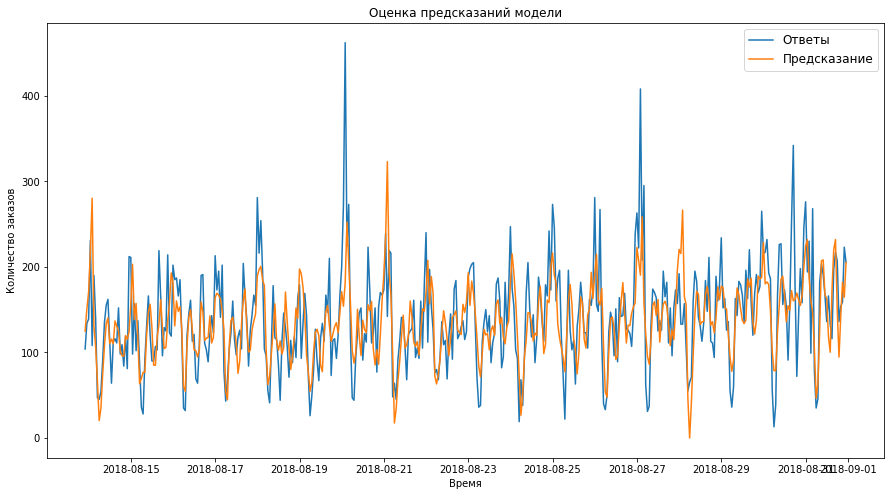

In [28]:
plt.figure(figsize=(15,8))
plt.title('Оценка предсказаний модели')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.plot(y_test, label='Ответы')
plt.plot(y_test.index, model.predict(X_test), label='Предсказание')
plt.legend(loc='best', fontsize=12)
plt.show()

Как видно, моедль достаточно хорошо попадает в "ритм" ответов, но не справляется с большими выбросами.

## Выводы 

Проведя анализ данных, понял что представленый период слишком мал для вявления сезонности, а вот тренд отследить можно было, спрос на такси с аждым днем рос, возможно это сеззоный рост, как я сказал данных мало для днозначного определения.

На данных обучили 3 моедли, лучше всего себя показал Лес катбуст всего на чуть-чуть отстал. Заметил что очень сильно хависит качество от генерируемых вичей, причем для леса и катбуста выжны разные фичи и их количество.

В итоге получили Лес и метрикой RMSE 48.